<a href="https://colab.research.google.com/github/FtM1997/Alzheimer-s-disease-Paper/blob/main/Refined_Conv1D_code_Alzheimer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this python notebook, I am trying to implement this paper:

Using shallow neural networks with functional connectivity from EEG signals for early diagnosis of Alzheimer’s and frontotemporal dementia


In [44]:
import os
import numpy as np
import math
import random
from collections import Counter
from google.colab import files
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from PIL import Image
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import KFold
from tensorflow.keras.models import Sequential, Model, clone_model
from keras.optimizers import Adam
from tensorflow.keras.layers import Conv2D, Input, ConvLSTM2D,MaxPooling3D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Activation, GlobalAveragePooling2D, MaxPool2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, Callback, LearningRateScheduler
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications import VGG16, VGG19, ResNet50, InceptionV3, DenseNet121, EfficientNetB2
from tensorflow.keras.layers import LSTM, GRU, TimeDistributed, Input
from tensorflow.keras.models import load_model
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import shutil
import scipy



# 1. Load data

In [45]:
# %reset -f

In [46]:
# from google_drive_downloader import GoogleDriveDownloader as gdd
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [47]:
import os
dir = os.path.join('/content/drive/My Drive/','Alzheimer','EEG_full_4D_1Hz.mat')  # Path to the Data folder

In [48]:
data = scipy.io.loadmat(dir)
eeg_data = data['EEG']

In [49]:
eeg_data.shape

(65, 2500, 19, 74)

In [50]:
epoch_num=data['epoch_num']

In [51]:
epoch_num.shape

(1, 88)

# 2. Devide data

In [52]:
lobes = {
    'Pre-frontal': [1, 2],
    'Frontal': [3, 4, 11, 12, 17],
    'Temporal': [13, 14, 15, 16],
    'Parietal': [7, 8, 19],
    'Central': [5, 6, 18],
    'Occipital': [9, 10]
}

In [53]:
# Iterate over each subject's data
for subject_idx in range(eeg_data.shape[0]):
    subject_data = eeg_data[subject_idx, :, :,:]  # EEG data for the current subject

    # Create directory to save time-series
    save_dir = os.path.join('/content','Alzheimer','Time_series')
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    # Iterate over each channel
    # channels_of_interest = [17,18]

    # for channel_idx in channels_of_interest:
    for channel_idx in range(subject_data.shape[1]):
        channel_data = subject_data[:,channel_idx, :]  # EEG data for the current channel

        # Iterate over each 10-second segment
        for seg_idx in range(epoch_num[0,subject_idx]):

            segment_data = channel_data[:,seg_idx]      # EEG data for the current Segment

            # Save all time-series
            save_path = os.path.join(save_dir, 'All lobes',f'subject{subject_idx + 1}')
            if not os.path.exists(save_path):
                os.makedirs(save_path)
            save_path2 = os.path.join(save_path, f'subject{subject_idx + 1}_channel{channel_idx + 1}_segment{seg_idx + 1}')
            np.save(save_path2,segment_data)



            # Save spectrogram image for each lobe
            for lobe_name, lobe_channels in lobes.items():
                if channel_idx + 1 in lobe_channels:
                    save_dir2 = os.path.join('/content/', 'Alzheimer', 'Time_series', lobe_name,f'subject{subject_idx + 1}')
                    if not os.path.exists(save_dir2):
                        os.makedirs(save_dir2)
                    save_path = os.path.join(save_dir2, f'subject{subject_idx + 1}_channel{channel_idx + 1}_segment{seg_idx + 1}')

                    np.save(save_path, segment_data)


print("saved successfully.")

saved successfully.


# Train/ Test Split

In [160]:
data_dir = '/content/Alzheimer/Time_series/All lobes'

def extract_numeric_part(folder_name):
    parts = folder_name.split('_')
    for part in parts:
        if part.startswith('subject'):
            return int(part.replace('subject', ''))
    return -1  # Return -1 if no numeric part is found

folders = sorted([f for f in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, f))], key=extract_numeric_part)

subject_folders, labels = [], []

for folder_name in folders:
    subject_num = extract_numeric_part(folder_name)
    subject_folder = os.path.join(data_dir, folder_name)
    subject_folders.append(subject_folder)

    if subject_num <= 36:
        labels.append(0)  # AD group
    elif 37 <= subject_num <= 65:
        labels.append(1)  # HC group

subject_folders = np.array(subject_folders)
labels = np.array(labels)

print("Subject Folders:", subject_folders)
print("Labels:", labels)

Subject Folders: ['/content/Alzheimer/Time_series/All lobes/subject1'
 '/content/Alzheimer/Time_series/All lobes/subject2'
 '/content/Alzheimer/Time_series/All lobes/subject3'
 '/content/Alzheimer/Time_series/All lobes/subject4'
 '/content/Alzheimer/Time_series/All lobes/subject5'
 '/content/Alzheimer/Time_series/All lobes/subject6'
 '/content/Alzheimer/Time_series/All lobes/subject7'
 '/content/Alzheimer/Time_series/All lobes/subject8'
 '/content/Alzheimer/Time_series/All lobes/subject9'
 '/content/Alzheimer/Time_series/All lobes/subject10'
 '/content/Alzheimer/Time_series/All lobes/subject11'
 '/content/Alzheimer/Time_series/All lobes/subject12'
 '/content/Alzheimer/Time_series/All lobes/subject13'
 '/content/Alzheimer/Time_series/All lobes/subject14'
 '/content/Alzheimer/Time_series/All lobes/subject15'
 '/content/Alzheimer/Time_series/All lobes/subject16'
 '/content/Alzheimer/Time_series/All lobes/subject17'
 '/content/Alzheimer/Time_series/All lobes/subject18'
 '/content/Alzheimer

In [161]:
def load_series_and_labels(subjects, labels):
    series, labels_t = [], []
    for subject_folder, label in zip(subjects, labels):
        for filename in os.listdir(subject_folder):
            series_path = os.path.join(subject_folder, filename.decode())
            try:
                ser = np.load(series_path)


                series.append(ser)
                labels_t.append(label)
            except Exception as e:
                print(f"Error loading time-series: {series_path}, {e}")

    return np.array(series), np.array(labels_t)


In [162]:
def load_and_preprocess_data(subject_folders, labels):
    train_subjects, test_subjects, train_labels, test_labels = train_test_split(subject_folders, labels, test_size=0.2, stratify=labels)

    train_subjects, val_subjects, train_labels, val_labels = train_test_split(train_subjects, train_labels, test_size=0.1, stratify=train_labels)

    train_series, train_labels_t = load_series_and_labels(train_subjects, train_labels)
    val_series, val_labels_t = load_series_and_labels(val_subjects, val_labels)

    test_image_counts_per_subject = [len(os.listdir(folder)) for folder in test_subjects]

    test_series, test_labels_t = load_series_and_labels(test_subjects, test_labels)

    return train_series, train_labels_t, val_series, val_labels_t, test_series, test_labels_t, test_subjects, test_image_counts_per_subject



# Conv1D

## Adapt data to the model definition

In [163]:
train_series, train_labels_t, val_series, val_labels_t, test_series, test_labels_t, test_subjects, test_image_counts_per_subject = load_and_preprocess_data(subject_folders, labels)

In [164]:
train_series = train_series[..., np.newaxis]  # Shape becomes (5445, 2500, 1)
val_series = val_series[..., np.newaxis]      # Shape becomes (831, 2500, 1)
test_series = test_series[..., np.newaxis]    # Shape becomes (1659, 2500, 1)

print("Training set shape:", train_series.shape)
print("Validation set shape:", val_series.shape)
print("Test set shape:", test_series.shape)
print("Training labels shape:", train_labels_t.shape)
print("Validation labels shape:", val_labels_t.shape)
print("Test labels shape:", test_labels_t.shape)


Training set shape: (36328, 2500, 1)
Validation set shape: (4978, 2500, 1)
Test set shape: (8949, 2500, 1)
Training labels shape: (36328,)
Validation labels shape: (4978,)
Test labels shape: (8949,)


## Model definition

In [165]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, BatchNormalization, MaxPooling1D, Flatten, Dense, Dropout

def create_cnn_model(input_shape, learning_rate):
    model = Sequential([
        # First block of conv, batch norm, and max pooling
        Conv1D(32, kernel_size=5, activation='relu', input_shape=input_shape),
        BatchNormalization(),
        MaxPooling1D(pool_size=2),

        # Second block of conv, batch norm, and max pooling
        Conv1D(32, kernel_size=5, activation='relu'),
        BatchNormalization(),
        MaxPooling1D(pool_size=2),

        Flatten(),
        Dense(64, activation='relu'),
        Dropout(0.4),  # Add dropout for regularization
        Dense(1, activation='sigmoid')
    ])

    return model

lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=7, min_lr=1e-6)

# Create the model with the correct input shape
model = create_cnn_model((2500, 1), 0.0001)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()



Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_26 (Conv1D)          (None, 2496, 32)          192       
                                                                 
 batch_normalization_26 (Ba  (None, 2496, 32)          128       
 tchNormalization)                                               
                                                                 
 max_pooling1d_26 (MaxPooli  (None, 1248, 32)          0         
 ng1D)                                                           
                                                                 
 conv1d_27 (Conv1D)          (None, 1244, 32)          5152      
                                                                 
 batch_normalization_27 (Ba  (None, 1244, 32)          128       
 tchNormalization)                                               
                                                     

## Train the model


In [166]:
hist = model.fit(train_series, train_labels_t, validation_data=(val_series, val_labels_t), epochs=25, batch_size=32, callbacks=[lr_scheduler])


Epoch 1/25
1136/1136 [==============================] - 13s 9ms/step - loss: 0.5331 - accuracy: 0.7305 - val_loss: 0.8087 - val_accuracy: 0.6464 - lr: 0.0010
Epoch 2/25
1136/1136 [==============================] - 10s 9ms/step - loss: 0.4282 - accuracy: 0.7836 - val_loss: 1.0406 - val_accuracy: 0.6332 - lr: 0.0010
Epoch 3/25
1136/1136 [==============================] - 11s 9ms/step - loss: 0.3531 - accuracy: 0.8267 - val_loss: 1.0507 - val_accuracy: 0.6474 - lr: 0.0010
Epoch 4/25
1136/1136 [==============================] - 10s 9ms/step - loss: 0.2891 - accuracy: 0.8612 - val_loss: 1.3371 - val_accuracy: 0.5930 - lr: 0.0010
Epoch 5/25
1136/1136 [==============================] - 10s 9ms/step - loss: 0.2405 - accuracy: 0.8889 - val_loss: 1.5254 - val_accuracy: 0.6362 - lr: 0.0010
Epoch 6/25
1136/1136 [==============================] - 10s 9ms/step - loss: 0.2035 - accuracy: 0.9062 - val_loss: 1.4908 - val_accuracy: 0.6458 - lr: 0.0010
Epoch 7/25
1136/1136 [==============================

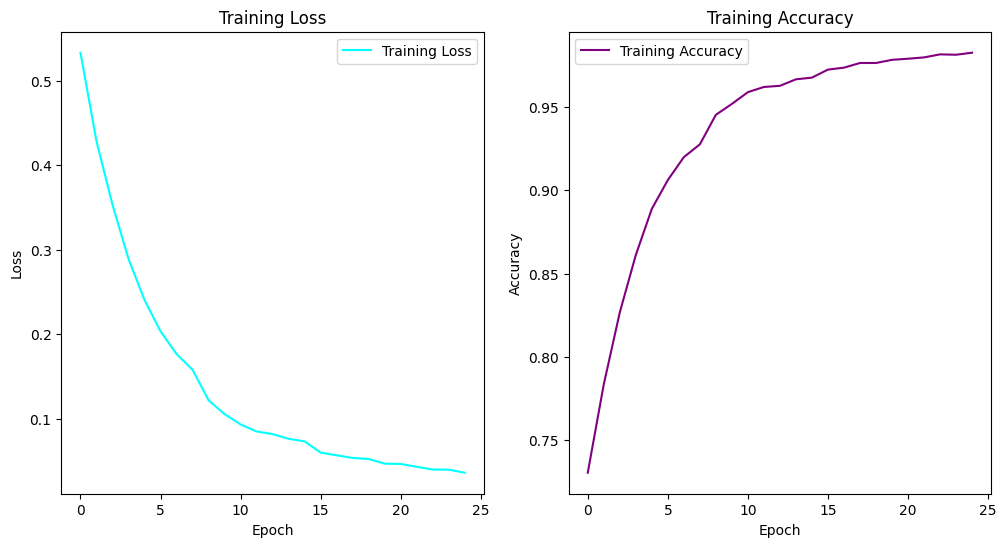

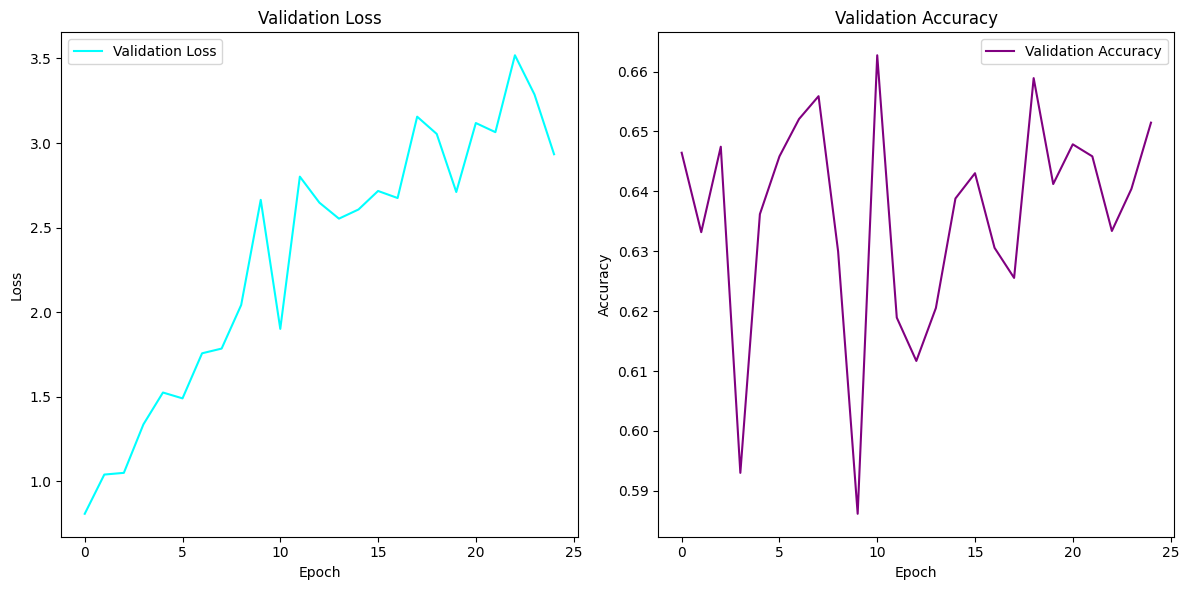

In [167]:
import matplotlib.pyplot as plt

# Plotting training loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(hist.history['loss'], label='Training Loss', color='cyan')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

# Plotting training accuracy
plt.subplot(1, 2, 2)
plt.plot(hist.history['accuracy'], label='Training Accuracy', color='purple')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')
plt.legend()

# Plotting validation loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(hist.history['val_loss'], label='Validation Loss', color='cyan')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Validation Loss')
plt.legend()

# Plotting validation accuracy
plt.subplot(1, 2, 2)
plt.plot(hist.history['val_accuracy'], label='Validation Accuracy', color='purple')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


## Test Model

In [169]:
# Evaluate the model
loss, accuracy = model.evaluate(test_series, test_labels_t)
print(f"Test loss: {loss}, Test accuracy: {accuracy}")

# # Make predictions
# predictions = model.predict(x_new_data)

# # Save the model
# model.save('my_model.h5')

# # Load the model (if needed later)
# from tensorflow.keras.models import load_model
# model = load_model('my_model.h5')


280/280 [==============================] - 1s 4ms/step - loss: 1.4490 - accuracy: 0.7119
Test loss: 1.4490445852279663, Test accuracy: 0.7119231224060059


# LSTM

In [ ]:
X = data_array
y = np.array([1]*36 + [0]*29)

import numpy as np
from sklearn.model_selection import train_test_split


# Normalize data
# X_normalized = X / np.max(X, axis=2, keepdims=True)
# should I normalize?


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,  shuffle = True)

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Model parameters
n_features = X_train.shape[2]  # number of features per timestep
n_outputs = 2  # number of output classes

n_features

1406

In [ ]:
model_LSTM = Sequential([
    LSTM(100, return_sequences=True, input_shape=(None, n_features)),
    Dropout(0.5),
    LSTM(50),
    Dense(n_outputs, activation='softmax')
])

model_LSTM.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_LSTM.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 100)         602800    
                                                                 
 dropout_4 (Dropout)         (None, None, 100)         0         
                                                                 
 lstm_1 (LSTM)               (None, 50)                30200     
                                                                 
 dense_8 (Dense)             (None, 2)                 102       
                                                                 
Total params: 633102 (2.42 MB)
Trainable params: 633102 (2.42 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)


In [ ]:
# Assuming X_train and y_train are your training data and labels
hist_LSTM = model_LSTM.fit(X_train, y_train, epochs=20, batch_size=64)

Epoch 1/20
1/1 [==============================] - 6s 6s/step - loss: 0.6925 - accuracy: 0.5962
Epoch 2/20
1/1 [==============================] - 0s 458ms/step - loss: 0.6660 - accuracy: 0.6346
Epoch 3/20
1/1 [==============================] - 1s 531ms/step - loss: 0.6480 - accuracy: 0.6346
Epoch 4/20
1/1 [==============================] - 1s 530ms/step - loss: 0.6382 - accuracy: 0.6346
Epoch 5/20
1/1 [==============================] - 1s 552ms/step - loss: 0.6259 - accuracy: 0.6346
Epoch 6/20
1/1 [==============================] - 1s 544ms/step - loss: 0.6136 - accuracy: 0.6346
Epoch 7/20
1/1 [==============================] - 1s 520ms/step - loss: 0.5990 - accuracy: 0.6346
Epoch 8/20
1/1 [==============================] - 1s 603ms/step - loss: 0.5818 - accuracy: 0.6346
Epoch 9/20
1/1 [==============================] - 1s 642ms/step - loss: 0.5499 - accuracy: 0.6346
Epoch 10/20
1/1 [==============================] - 1s 775ms/step - loss: 0.4738 - accuracy: 0.7308
Epoch 11/20
1/1 [=====

In [ ]:
X_test.shape

(13, 2500, 1406)

In [ ]:
# Evaluate the model
loss_LSTM, accuracy_LSTM = model_LSTM.evaluate(X_test, y_test)
print(f"Test loss: {loss_LSTM}, Test accuracy: {accuracy_LSTM}")

1/1 [==============================] - 5s 5s/step - loss: 2.4119 - accuracy: 0.5385
Test loss: 2.411938190460205, Test accuracy: 0.5384615659713745
